In [1]:
import torch
from torch.utils.data import DataLoader,Dataset,random_split
import pandas as pd
import os
import numpy as np
import itertools
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score,multilabel_confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tqdm import tqdm


import matplotlib.pyplot as plt
import concurrent.futures
import logging
import pypsg
import os
from psgDocker3 import get_data_async
from retrying import retry
#Use module 3.1.6 for mpi4py


def wavelengthFilter(string):
    '''
    This function removes the um suffix from the wavelength data.

    Inputs
    ------
    string: A string to remove um from.

    Returns
    -------
    string: A float
    '''
    string=string.removesuffix(" um")
    return float(string)

def getAbundances(fileName):
    '''
    This function grabs the molecule abundances from the config files and returns them as a vector

    Inputs
    ------
    fileName: The name of the config file.

    Returns
    -------
    abundances: A vector containing the abundance information
    '''
    abundances=[0.0]*7
    moleculeNames=["O2", "N2", "CO2", "H2O", "N2O", "CH4", "H2S"]
    lines=[]
    with open(fileName) as f:
        for line in f:
            lines.append(line)

    abundances=lines[54]
    abundances=abundances.removeprefix("<ATMOSPHERE-LAYER-1>")
    abundances=abundances.split(",")

    if "None" in os.path.basename(fileName):
        #Special case
        abundances=list(map(float,abundances[2:9]))#Only gets target values, not background moolecules or 

    else:
        abundances=list(map(float,abundances[2:]))#Remove temperature profile information
    return abundances

class customDataset(Dataset):
    def __init__(self,samples):#samples contain a listt of all file paths
        self.samples=samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,index):
        filePath=self.samples[index]


        configFilePath=r"C:\Users\Tristan\Downloads\HyPCAR3\configFiles\\"
        # configFilePath="/home/tristanb/scratch/configFiles/"
        fileName=os.path.basename(filePath)
        fileName=fileName.removesuffix(".csv")
        configFilePath+=fileName+".txt"

        label=getAbundances(configFilePath)
        #Extract data from file
        data=pd.read_csv(filePath)
        wavelength=list(map(wavelengthFilter,data.iloc[:,0]))#Removes um from wavelength data
        transmittance=list(data.iloc[:,1])

        combinedData=torch.tensor(list(zip(wavelength, transmittance)), dtype=torch.float32)

        return combinedData,torch.tensor(label),configFilePath
    


def testNewAbundances(fileNames,moleculeAbundances):
    '''
    This function will update a temporary config file with the predictions from the ml model. 
    This is for the PSG-based loss, it takes in a batch of 32 different files and abundances. If this

    Inputs
    -----
    fileNames: The names of the config files
    moleculeAbundances: The new predicted abundances from the model.

    Returns
    -------
    combinedData: A tensor that contains the new wavelength and transmittance values for the updated abundances
    '''
    #Fix this functino, doesn't work because stupid batches. really really annoying, can think about using dask
    #To speed up the process because I'm dealing with about 32 files.
    #Super annoying, will create something called a "working directory" where I will store the modified config files per batch
    #Then use batch to run data through them, will need to pretty much rewrite everything here
    workingDirectory=[]
    for index,file in enumerate(fileNames):
        
        lines=[]
        with open(file) as f:
            for line in f:
                lines.append(line)
        
        #C:\Users\Tristan\Downloads\HyPCAR\workingDirectory\working-0.txt
        workingConfigFilePath=r"C:\Users\Tristan\Downloads\HyPCAR\workingDirectory\working-" +f"{index}.txt"
        #Deal with atmosphere layers here
        #Start line is 54

        abundanceDictionary={}
        molecules=["O2","N2","H2","CO2","H2O","CH4","NH3"]
        for i in range(len(moleculeAbundances[index])):
            abundanceDictionary[molecules[i]]=moleculeAbundances[index][i].cpu().item()

        moleculeWeights={"O2":31.999, "N2":28.02, "H2":2.016,"CO2":44.01, "H2O":18.01528,"CH4":16.04,"NH3":17.03052 }#g/mol
        averageWeight=0
        for molecule in abundanceDictionary:
            averageWeight+=moleculeWeights[molecule]*abundanceDictionary[molecule]
        


        for i in range(50):
            atmosphereInfo=lines[54+i]
            atmosphereInfo=atmosphereInfo.removeprefix("<ATMOSPHERE-LAYER-"+str(i+1)+">")
            atmosphereInfo=atmosphereInfo.removesuffix("\n")
            atmosphereInfo=atmosphereInfo.split(",")

            atmosphereInfo[2:]=moleculeAbundances[index].tolist()
            
    

            lines[54+i]="<ATMOSPHERE-LAYER-"+str(i+1)+">"+",".join(map(str,list(atmosphereInfo)))+"\n"
        
        nMolecules=7

        HITRANValues={"O2":"HIT[7]","N2":"HIT[22]","H2":"HIT[45]","CO2":"HIT[2]","H2O":"HIT[1]","CH4":"HIT[6]","NH3":"HIT[11]"}

        #Additional parameters to actually run the data properly.
        lines[42]="<ATMOSPHERE-NGAS>"+str(len(moleculeAbundances[index]))+"\n" #Number of gases are in the atmosphere
        lines[43]="<ATMOSPHERE-GAS>"+",".join(molecules)+"\n" #What gases are in the atmosphere
        lines[44]="<ATMOSPHERE-TYPE>"+",".join(HITRANValues[mol] for mol in molecules)+"\n" #HITRAN values for each gas
        lines[45]="<ATMOSPHERE-ABUN>"+"1,"*(len(moleculeAbundances[index])-1)+"1"+"\n" #Molecule abunadnces. They're all 1, because abundances are defined in vertical profile
        lines[46]="<ATMOSPHERE-UNIT>"+"scl,"*(len(moleculeAbundances[index])-1)+"scl"+"\n" #Abundance unit
        lines[49]="<ATMOSPHERE-WEIGHT>"+str(averageWeight)+"\n" #Molecule weight of atmosphere g/mol
        lines[52]="<ATMOSPHERE-LAYERS-MOLECULES>"+",".join(molecules)+"\n" #Molecule in vertical profile

        with open(workingConfigFilePath,"w") as f:
            f.writelines(lines)
        workingDirectory.append(workingConfigFilePath)
    
    return get_data_async()#Calls the PSG docker to get the data

class detectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv1d(in_channels=2, out_channels=128, kernel_size=5, stride=2)
        self.bn1=nn.BatchNorm1d(128)
        self.pool1=nn.MaxPool1d(2)

        self.conv2=nn.Conv1d(in_channels=128,out_channels=128,kernel_size=5,stride=2)
        self.bn2=nn.BatchNorm1d(128)
        self.pool2=nn.MaxPool1d(2)

        self.conv3=nn.Conv1d(in_channels=128,out_channels=64,kernel_size=3,stride=2)
        self.bn3=nn.BatchNorm1d(64)
        self.pool3=nn.MaxPool1d(2)

        self.conv4=nn.Conv1d(in_channels=64,out_channels=32,kernel_size=2,stride=2)
        self.bn4=nn.BatchNorm1d(32)
        self.pool4=nn.MaxPool1d(2)

        self.dropout1=nn.Dropout(0.4)

        self.global_pool = nn.AdaptiveAvgPool1d(1)



        self.fc1=nn.Linear(32,128)
        self.dropout2=nn.Dropout(0.75)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,7)#7 molecule present

    def forward(self,x):
        # Permute dimensions to [batch_size, channels, sequence_length]
        x=x.permute(0, 2, 1)
        x=F.relu(self.bn1(self.conv1(x)))
        x=self.pool1(x)

        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool2(x)

        x=F.relu(self.bn3(self.conv3(x)))
        x=self.pool3(x)

        x=F.relu(self.bn4(self.conv4(x)))
        x=self.pool4(x)

        x=self.dropout1(x)

        x=self.global_pool(x)
        x=torch.flatten(x,1)

        x=F.relu(self.fc1(x))
        x=self.dropout2(x)

        x=F.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))

        return x
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.fc_out = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()

        # Linear projections for Q, K, V
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Split into heads
        Q = Q.view(batch_size, seq_length, self.num_heads, input_dim // self.num_heads)
        K = K.view(batch_size, seq_length, self.num_heads, input_dim // self.num_heads)
        V = V.view(batch_size, seq_length, self.num_heads, input_dim // self.num_heads)

        # Transpose to (batch, heads, seq_len, feature_dim)
        Q = Q.permute(0, 2, 1, 3)
        K = K.permute(0, 2, 1, 3)
        V = V.permute(0, 2, 1, 3)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-1, -2)) / (input_dim ** 0.5)
        attention_weights = self.softmax(scores)

        # Weighted sum of values
        weighted_sum = torch.matmul(attention_weights, V)

        # Concatenate heads and apply linear projection
        weighted_sum = weighted_sum.permute(0, 2, 1, 3).contiguous()
        weighted_sum = weighted_sum.view(batch_size, seq_length, input_dim)

        # Output linear layer
        out = self.fc_out(weighted_sum)

        return out, attention_weights


class abundanceModel(nn.Module):#CHange to output uncertainty as well
    def __init__(self):
        super().__init__()

        self.fcDetect=nn.Linear(7, 64)


        self.conv1=nn.Conv1d(in_channels=2, out_channels=256, kernel_size=5, stride=2)
        self.bn1=nn.BatchNorm1d(256)
        self.pool1=nn.MaxPool1d(2)

        self.conv2=nn.Conv1d(in_channels=256,out_channels=512,kernel_size=7,stride=1)
        self.bn2=nn.BatchNorm1d(512)
        self.pool2=nn.MaxPool1d(2)

        self.conv3=nn.Conv1d(in_channels=512,out_channels=256,kernel_size=5,stride=2)
        self.bn3=nn.BatchNorm1d(256)
        self.pool3=nn.MaxPool1d(2)

        self.conv4=nn.Conv1d(in_channels=256,out_channels=64,kernel_size=2,stride=2)
        self.bn4=nn.BatchNorm1d(64)
        self.pool4=nn.MaxPool1d(2)

        self.dropout1=nn.Dropout(0.329397809173006)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.attention=MultiHeadAttention(input_dim=64, num_heads=16)


        self.fc_combined=nn.Linear(128, 128)#Combines both input branches (detection + data)


        self.flatten=nn.Flatten()


        self.dropout2=nn.Dropout(0.502219550897328)
        self.fc2=nn.Linear(128,64)

        self.fc3=nn.Linear(64,32)
        self.fc4=nn.Linear(32,7)#7 molecule present

        #Another branch for uncertaintiy values for each molecule
        self.fc_uncertainty=nn.Linear(32,7)

    def forward(self,x,detectionOutput):

        detectionOutput=F.relu(self.fcDetect(detectionOutput))


        #Permute dimensions to [batch_size, channels, sequence_length]
        x=x.permute(0, 2, 1)
        x=F.relu(self.bn1(self.conv1(x)))
        x=self.pool1(x)

        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool2(x)

        x=F.relu(self.bn3(self.conv3(x)))
        x=self.pool3(x)

        x=F.relu(self.bn4(self.conv4(x)))
        x=self.pool4(x)


        x=self.dropout1(x)




        x=x.permute(0, 2, 1)
        x,attention_weights=self.attention(x)
        x=x.permute(0,2,1)
        x=self.global_pool(x)

        x=x.squeeze(-1)


        combined=torch.cat((x,detectionOutput), dim=1)
        combined=F.relu(self.fc_combined(combined))
        combined=F.relu(self.fc2(combined))
        combined=F.relu(self.fc3(combined))


        #Abundance branch
        logits=self.fc4(combined)
        #Apply softmax to make the output sum to 1 for abundances
        abundances=F.softmax(logits, dim=1)


        uncertaintyRaw=self.fc_uncertainty(combined)
        uncertainties=F.softplus(uncertaintyRaw)#Soft plus, since we don't want to bound to 1

        #In www.conf, found in etc php-fpm.d
        #listen = /tmp/run/php-fpm
        #And commented out listen.acl_gorups=apache,nginx
        #listen.moded=0666

        #Changed in etc/php-fpm.conf
        #Changed pid to equal /tmp/php-fpm.pid
        return abundances,uncertainties,attention_weights

    
def calculateChiSquared(yPred,yReal,sigma):
    chiElements=((yPred-yReal)**2)/(sigma**2)
    total=torch.sum(chiElements)
    totalPoints=yPred.numel()

    chiVal=total/totalPoints
    return chiVal.item()

molecules=["O2","N2","H2","CO2","H2O","CH4","NH3"]
trueMoleculeAbun={mol:[] for mol in molecules}
predMoleculeAbun={mol:[] for mol in molecules}


random.seed(42)


testingData=[]


if __name__=="__main__":

    testSplit=0.1
    for atmosphereType in ["A","B","C"]:
        curFolderPath=r"C:\Users\Tristan\Downloads\HyPCAR3\data"
        curFolderPath+="\\"+atmosphereType
        files=[]
        for path in os.listdir(curFolderPath):
            #Need to get molecule abundances as well, this means that for each file, I need to go to the config file
            #Then extract the abundances there
            #This is how I will get the one-hot vector for the presence
            #Will just write a functionn

            files.append(os.path.join(curFolderPath,path))

        random.shuffle(files)

        testingSamples=[]
        for i,data in enumerate(files):
            path=data
            if i<(len(files)*testSplit):#Adds testing data
                testingSamples.append((path))
            else:
                break
        testingData.extend(testingSamples)

    print("DONE")


    random.shuffle(testingData)
    testingDataset=customDataset(testingData)
    testingDataloader=DataLoader(testingDataset,batch_size=32,shuffle=True)#Testing data loader

    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model=abundanceModel()
    model.load_state_dict(torch.load(r"C:\Users\Tristan\Downloads\HyPCAR3\finalBaseAbundance.pt",weights_only=True))
    model=model.to(device)


    detect=detect=detectionModel()
    detect.load_state_dict(torch.load(r"C:\Users\Tristan\Downloads\HyPCAR3\flexibleDetectionModel.pt",weights_only=True))
    detect=detect.to(device)


    model.eval()
    detect.eval()
    with torch.no_grad():


        total=0
        totalSamples=0
        counter=0
        for batch in tqdm(testingDataloader):
            data,labels,configs=batch

            data=data.to(device)
            labels=labels.to(labels)
            detectionOutput=detect(data)
        

            predAbun,uncertainties,attentionWeights=model(data,detectionOutput)
            for i,molecule in enumerate(molecules):
                for batch in range(len(labels)):
                    # print(labels[0].tolist()[i])
                    # print(len(labels))
                    trueMoleculeAbun[molecule].append(labels[batch].tolist()[i])
                    predMoleculeAbun[molecule].append(predAbun[batch].tolist()[i])



DONE


100%|██████████| 563/563 [04:02<00:00,  2.32it/s]


O2: 0.7311379794981759


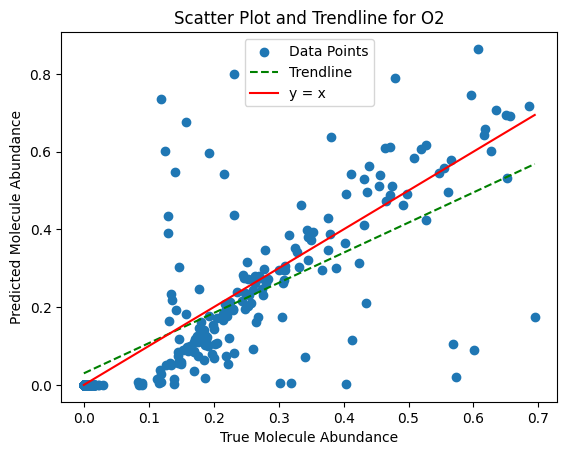

N2: 0.4252972456130047


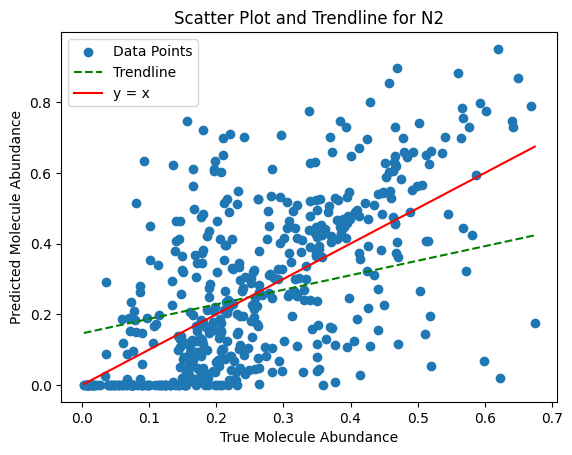

H2: 0.6572977800728548


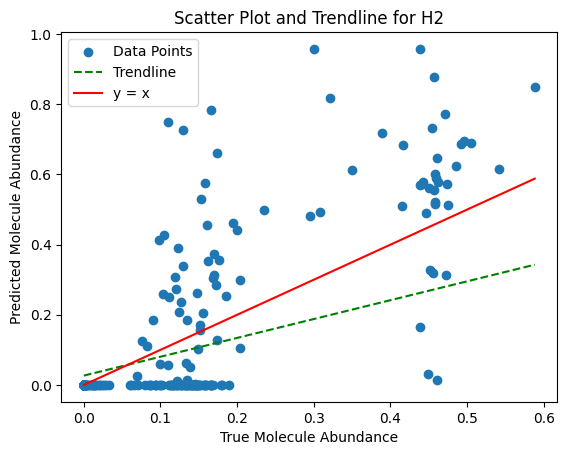

CO2: 0.5840393957165316


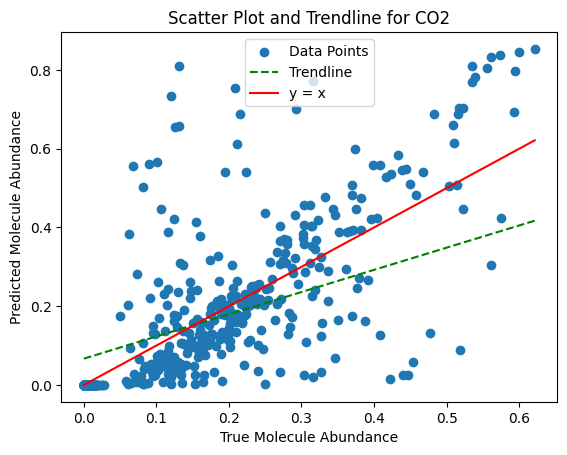

H2O: 0.4813320129658193


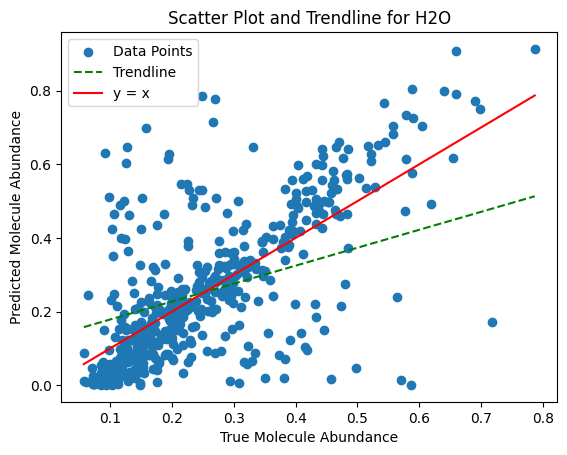

CH4: 0.6603395330427115


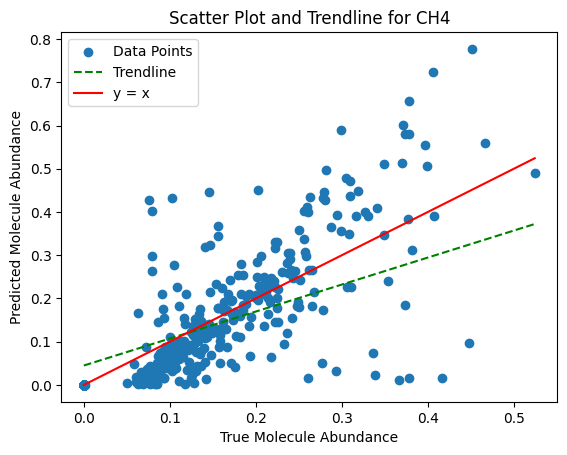

NH3: 0.7603069781361089


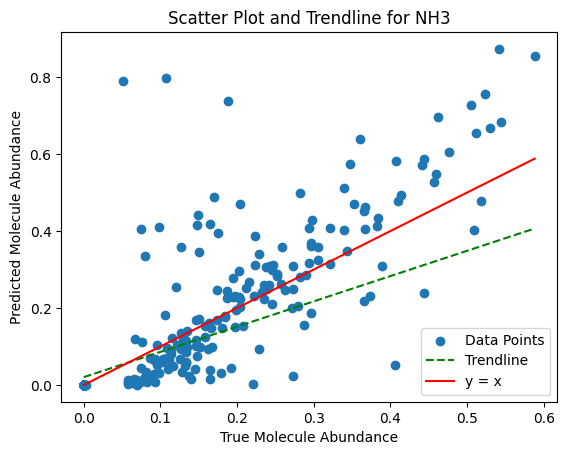

HERE:
0.6142501321493153


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
random.seed(117)




average=0
for i, molecule in enumerate(molecules):
    plt.figure(i)
    test=[(predMoleculeAbun[molecule][j],trueMoleculeAbun[molecule][j]) for j in range(len(predMoleculeAbun[molecule]))]

    testValues=random.sample(test,500)
    y,x=list(zip(*testValues))
    y,x=np.array(x),np.array(y)

    # Extract data for easier manipulation
    # y = np.array(predMoleculeAbun[molecule])
    # x = np.array(trueMoleculeAbun[molecule])
    
    # Scatter plot of the data points
    plt.scatter(x, y, label='Data Points')
    

    

    x_range = np.linspace(x.min(), x.max(), 100)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y,x)
    y_trendline = slope * x_range + intercept

    print(f"{molecule}: {r_value**2}")

    plt.plot(x_range, y_trendline, "g--", label='Trendline')


    # Plot the y=x reference line
    plt.plot(x_range, x_range, color='red', label='y = x')
    
    # Add titles and labels for clarity
    plt.xlabel('True Molecule Abundance')
    plt.ylabel('Predicted Molecule Abundance')
    plt.title(f'Scatter Plot and Trendline for {molecule}')
    plt.legend()
    
    plt.show()
    average+=r_value**2
print("HERE:")
print(average/7)


DONE


100%|██████████| 563/563 [01:01<00:00,  9.16it/s]

296.5487878781255
822.3449466120247
219.38520406699357
425.3495394719118
520.5212840465157
381.5624993821378
164.65394309699644
